In [1]:
#----------------------------#
# 0.) Idea
#----------------------------#
# Get PCA over comments data
#
# Approaches: 
# 1.) Extract embeddings Code
# 2.) PCA  Code
# 3.)Test Case
# 4.) Run
#
import sys
#import praw
#from praw.models import MoreComments
import pandas as pd
import numpy as np
#import re
from urlextract import URLExtract 
from datetime import datetime, timedelta
from collections import Counter
#from urlextract import URLExtract 
#from tldextract import extract
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
#import nltk
#from nltk.corpus import stopwords
#from nltk.tokenize import RegexpTokenizer
#from scipy import spatial
import import_ipynb
import math

In [2]:
home_path = %pwd
data_path = "/home/pavel/Documents/Keusch_Job/Data/"
plot_path  = "/home/pavel/Documents/Keusch_Job/Tasks/subreddit_decide/"
subroutines_path = "/home/pavel/Documents/Keusch_Job/Subroutines/"

In [3]:
#Subroutines
%cd  $subroutines_path
%run "selected_subreddits.ipynb"
%run "data_loader.ipynb"
%cd  $home_path

/home/pavel/Documents/Keusch_Job/Subroutines
/home/pavel/Documents/Keusch_Job/Tasks/subreddit_decide


In [4]:
#----------------------------#
# 1.) Extract embeddings Code
#----------------------------#

In [4]:
# WARNING: download through http link takes almost 30minutes
# Thats why I have it on disc in the data path
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
#model = hub.load(module_url)
#thx to https://stackoverflow.com/questions/50322001/how-to-save-load-a-tensorflow-hub-module-to-from-a-custom-path
module_url = data_path + "universal-sentence-encoder_4"
embed_model = hub.load(module_url)

In [5]:
def embed(input): return embed_model(input)
def tf_simil(s1,s2): return np.inner(s1,s2) # inner Product as similarity! cool, but why inner product? 
# wouldn't you take cosine? 
def tf_simil_matrix(embeddings, rd = 8): return [[round(tf_simil(s1,s2),rd) for s1 in embeddings] for s2 in embeddings]

In [6]:
def emb_dict_from_df(comment_df):
    emb_dict = {}
    for i in range(0,len(comment_df)):
        print(str(i) +  ":" + comment_df["id"].iloc[i])
        if isinstance(comment_df["body"].iloc[i], str):
            emb_dict[comment_df["id"].iloc[i]] = embed([comment_df["body"].iloc[i]])
        else:
            emb_dict[comment_df["id"].iloc[i]] = "NAN"
    return(emb_dict)

In [29]:
def emb_array_from_df(comment_df):
    emb_matrix = np.append(embed([comment_df["body"].iloc[0]]),embed([comment_df["body"].iloc[1]]),axis=0)
    for i in range(2,len(comment_df)):
        print(str(i))
        if isinstance(comment_df["body"].iloc[i], str):
            emb_matrix = np.append(emb_matrix, embed([comment_df["body"].iloc[i]]),axis=0)
        else:
            na_vector = np.full((1,512),999)
            emb_matrix = np.append(emb_matrix, na_vector,axis=0)
    return(emb_matrix)

In [8]:
#----------------------------#
# 2.) PCA  Code
#----------------------------#

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
MDS_embedding = MDS(n_components=2)
%matplotlib inline
import seaborn as sns

In [12]:
def dict_2_matrix(c_dict, key_list, print_iter = True):
    #s_dict: some dictionary where the values are embedings ()
    #key_list: a list of keys
    #RETURNS: the np.array matrix where each value is a row.
    emb_matrix = np.append(c_dict[key_list[0]], c_dict[key_list[1]],axis=0)
    for i in range(2,len(key_list)):
        if print_iter:
            print(str(i))
        emb_matrix = np.append(emb_matrix, c_dict[key_list[i]],axis=0)
    return(emb_matrix)

In [13]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.0002, point['y'], str(point['val']), alpha = 0.5)

In [41]:
def emb_plot(emb_matrix, plot_path = plot_path , file_name = "subreddits_avg_emb_PCA_labels",
             label_series = selected_subreddits["subreddit"], main_title = "subreddits PCA",
             legend = True, plot_labels= False, MDS = False):
    
    # PCA
    if MDS:
        category_vectors = MDS_embedding.fit_transform(emb_matrix.T)
    else:
        model = PCA(n_components=2).fit(emb_matrix)
        category_vectors = model.components_.T
    #    # transform df
    category_vector_frame=pd.DataFrame(category_vectors, index = label_series.tolist(), #index=subr_list, 
                                   columns=['col1', 'col2']).reset_index()
    #
    #Plot 
    plt.figure(figsize=(10, 10))
    if legend:
        sns.scatterplot(data=category_vector_frame, x='col1', y='col2',hue='index');
        plt.legend(loc='upper right')
    else:
        sns.scatterplot(data=category_vector_frame, x='col1', y='col2');
    if plot_labels:
        # need to do it because https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values
        label_series_2 = label_series.copy()
        label_series_2.reset_index(drop=True, inplace=True)
        label_point(category_vector_frame.col1, category_vector_frame.col2,label_series_2, plt.gca())
    plt.title(main_title, size=20)
    plt.savefig(fname=plot_path + file_name)

In [ ]:
#----------------------------#
# 3.) Test Case
#----------------------------#

In [ ]:
C = load_data(data_name="COMM_2020_04.csv", data_path = data_path)
conservative_comments = C.loc[C["subreddit"] == "Conservative",]
print(len(conservative_comments))
del C

In [38]:
#conservative_emb_matrix= emb_array_from_df(conservative_comments.iloc)
conservative_emb_matrix_test= emb_array_from_df(conservative_comments.iloc[0:300])
conservative_emb_matrix_test = conservative_emb_matrix_test.T

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

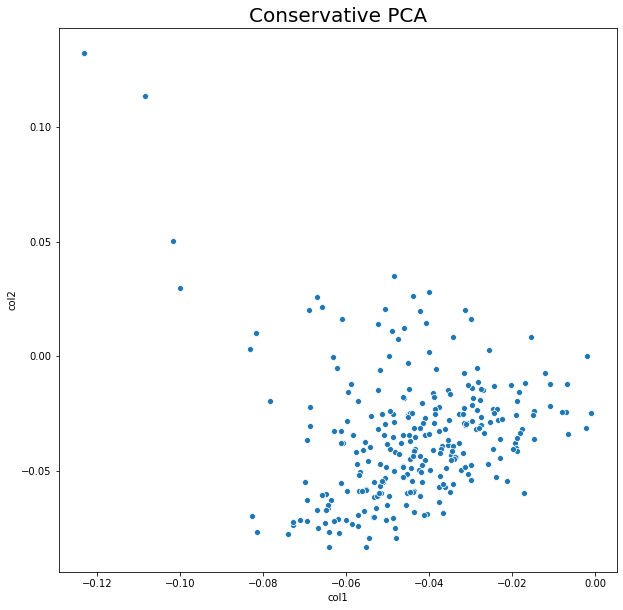

In [43]:
emb_plot(conservative_emb_matrix_test,  plot_path = plot_path , file_name = "Conservative_Comments_PCA_sample",
        label_series = conservative_comments["body"].iloc[0:300], main_title ="Conservative PCA",
         legend = False, plot_labels= False,MDS = False)

In [ ]:
#----------------------------#
# 4.) Run
#----------------------------#

In [53]:
def processing_and_plot(subreddit_name, data_path = data_path, data_name = "COMM_2020_04.csv",
                        plot_path = plot_path, 
                        file_name = "Comments_PCA", main_title = "Comments PCA"):
    # Load
    C = load_data(data_name=data_name, data_path = data_path)
    comments_df = C.loc[C["subreddit"] == subreddit_name,]
    print("Loading "+ subreddit_name + " Rows: " + str(len(comments_df)))
    if len(comments_df) < 1:
        print("No Comments available")
    else:
        del C
        ## Get Embeddinga
        comments_emb_matrix = emb_array_from_df(comments_df)
        comments_emb_matrix = comments_emb_matrix.T
        #Plot
        emb_plot(comments_emb_matrix,  plot_path = plot_path , file_name =file_name,
                 label_series = comments_df["body"], main_title =main_title,
                 legend = False, plot_labels= False,MDS = False)

In [56]:
#processing_and_plot("Conservative", data_path = data_path, data_name = "COMM_2020_04.csv",
#                        plot_path = plot_path, 
#                        file_name = "Conservative_Comments_PCA",
#                        main_title = "Conservative Comments PCA")

In [55]:
processing_and_plot("test", data_path = data_path, data_name = "COMM_2020_04.csv",
                        plot_path = plot_path, 
                        file_name = "Conservative_Comments_PCA",
                        main_title = "Conservative Comments PCA")

Loading test Rows: 0
No Comments available


In [59]:
subr_list = selected_subreddits["subreddit"].tolist()

In [ ]:
for s in subr_list:
    processing_and_plot(s, data_path = data_path, data_name = "COMM_2020_04.csv",
                        plot_path = plot_path, 
                        file_name = s + "_Comments_PCA",
                        main_title = s + " Comments PCA")

In [ ]:
# TO DO:
# S0: Titel on plots
# S1: Check out these sparse matrices
# S2: Structure and optimize code
#
# S3: Clustering
# S4: Regex resultate in Raum plotten
# S5: S1 und S2 overlap